# 0.0. Imports

In [2]:
import os
import sys

import numpy as np
import pandas as pd
from sklearn.svm import SVR
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression

sys.path.insert(0, "../src/")
sys.path.append(os.path.join(os.path.abspath(""), "../src/data_process"))
sys.path.append(os.path.join(os.path.abspath(""), "../src/training_model"))
sys.path.append(os.path.join(os.path.abspath(""), "../config"))

from data_process.process_data import processing_data
from data_process.reframe_data import DataReframing
from config import validation_size, num_folds, scoring
from training_model.data_preparation import DataPreparation

# 1.0. Data loading and processing

In [3]:
df = processing_data()

In [5]:
dr = DataReframing(df)
_, X, Y = dr.reframing_data()

# 2.0. Data preparation

## 2.1. Feature selection

In [6]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
featureScores.nlargest(10,'Score').set_index('Specs') 

,Score
Specs,
JPM_3DT,1.112979
VIXCLS,0.815158
DEXUSEU,0.527937
BAC,0.514963
JPM_6DT,0.286269
DJIA,0.175721
SP500,0.083302
DEXUSUK,0.069732
WFC,0.055490


Podemos identificar a variável JPM_3DT sendo a variável mais importante e a variável JPM_12DT a menos importante.

## 2.2. Data preparation

In [7]:
data_prep = DataPreparation(validation_size)

## 2.3. Split data into training and testing

In [8]:
X_train, Y_train = data_prep.create_training_data(X, Y)
X_test, Y_test = data_prep.create_testing_data(X, Y)

# 3.0. Compare models

## 3.1. Defining algorithms

In [9]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

## 3.2. Run experiments

In [10]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    ## k-fold analysis:
    kfold = KFold(n_splits=num_folds)
    #converted mean squared error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    msg = f"Algoritmo: {name}, Media: {cv_results.mean():.6f}±{cv_results.std():.6f}. Resultado do treino:{train_result:.6f} e do teste {test_result:.6f}"
    print(msg)

Algoritmo: LR, Media: 0.001143±0.000674. Resultado do treino:0.001012 e do teste 0.001438
Algoritmo: LASSO, Media: 0.001055±0.000603. Resultado do treino:0.001045 e do teste 0.001443
Algoritmo: EN, Media: 0.001055±0.000603. Resultado do treino:0.001045 e do teste 0.001443
Algoritmo: KNN, Media: 0.001215±0.000585. Resultado do treino:0.000849 e do teste 0.001481
Algoritmo: CART, Media: 0.002208±0.000847. Resultado do treino:0.000000 e do teste 0.002638
Algoritmo: SVR, Media: 0.001324±0.000875. Resultado do treino:0.001138 e do teste 0.001695
Algoritmo: MLP, Media: 0.001342±0.000693. Resultado do treino:0.001318 e do teste 0.002002
Algoritmo: ABR, Media: 0.001211±0.000691. Resultado do treino:0.000733 e do teste 0.001635
Algoritmo: GBR, Media: 0.001321±0.000779. Resultado do treino:0.000250 e do teste 0.001761
Algoritmo: RFR, Media: 0.001206±0.000669. Resultado do treino:0.000168 e do teste 0.001594
Algoritmo: ETR, Media: 0.001234±0.000693. Resultado do treino:0.000000 e do teste 0.00168

## 3.3. Evaluating

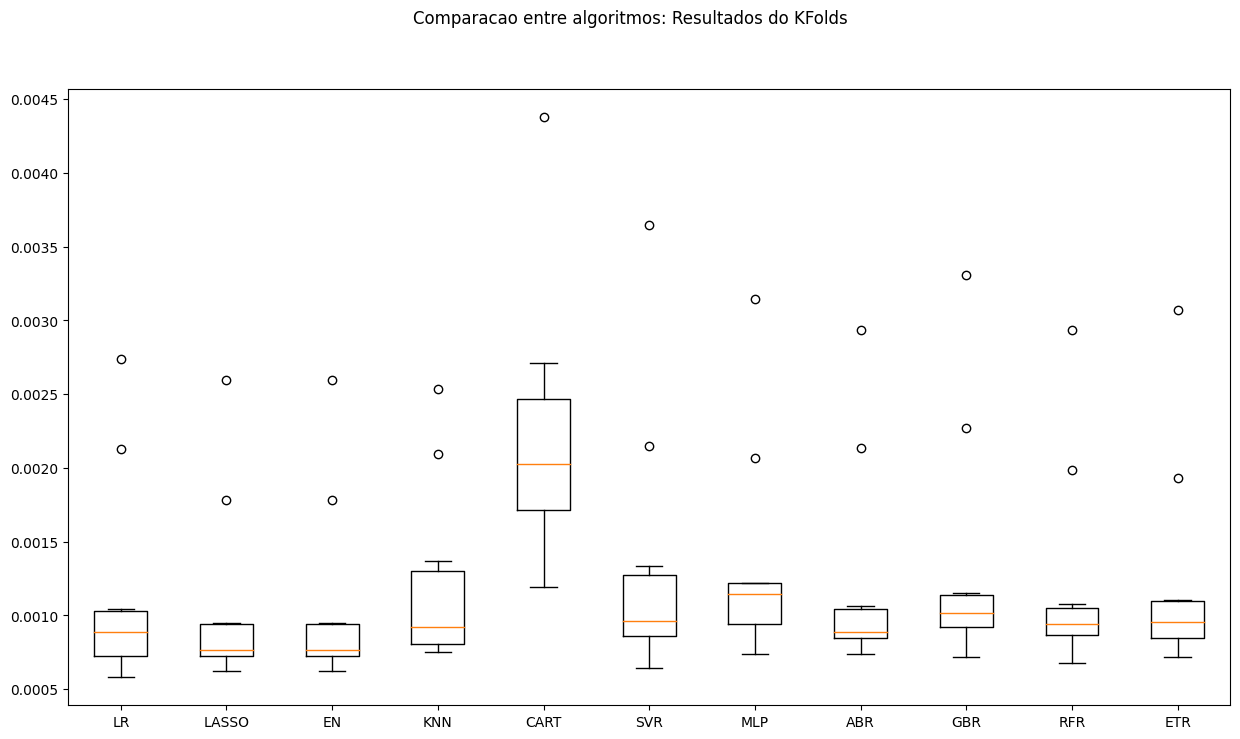

In [11]:
fig = plt.figure()
fig.suptitle('Comparacao entre algoritmos: Resultados do KFolds')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

Podemos identificar os algoritmos LASSO e ElasticNet como bons preditores, dado que tiveram as menores métricas de avaliação entre todos os outros.

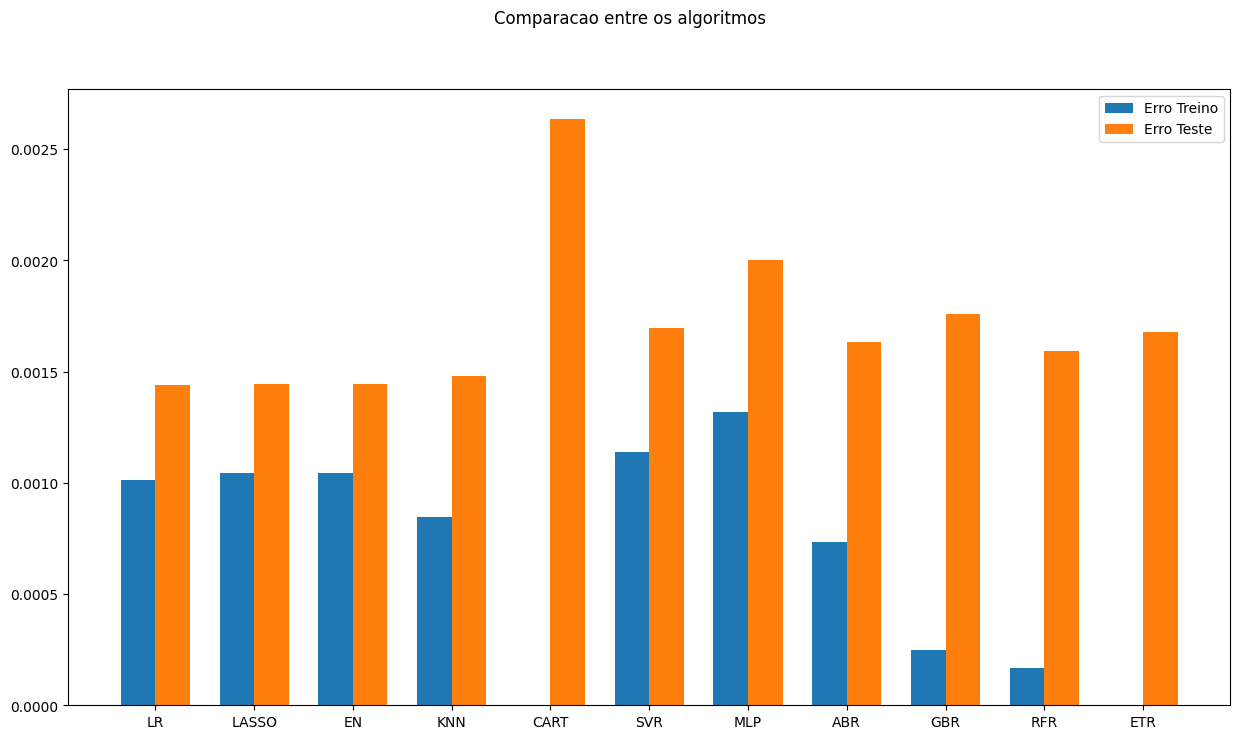

In [12]:
fig = plt.figure()
ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Comparacao entre os algoritmos')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results, width=width, label='Erro Treino')
plt.bar(ind + width/2, test_results, width=width, label='Erro Teste')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

Olhando as barras de erros entre treino e teste ainda conseguimos validar que os modelos lineares estão capturando melhor o padrão dos dados e realizando melhores previsões nos dados de teste. Além disso podemos afirmar que os algoritmos DecisionTreeRegressor e ExtraTreeRegressor está ocorrendo o overfitting.

## 3.4. ARIMA experiment

Além dos algoritmos anteriores, vamos também executar o algoritmo ARIMA, mas antes vamos selecionar somente as variávels correlacionadas como exógenas.

In [13]:
X_train_ARIMA=X_train.loc[:, ['BAC', 'WFC', 'DEXUSUK', 'DEXUSEU', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['BAC', 'WFC', 'DEXUSUK', 'DEXUSEU', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [14]:
modelARIMA=sm.tsa.arima.ARIMA(endog=Y_train,
                 exog=X_train_ARIMA,
                 order=[1,0,0])
model_fit = modelARIMA.fit()

/home/matheus/Documents/repos/stock_price_prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/matheus/Documents/repos/stock_price_prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/matheus/Documents/repos/stock_price_prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, \
exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

/home/matheus/Documents/repos/stock_price_prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/matheus/Documents/repos/stock_price_prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


0.0014891036794249146

## 3.5. Evaluating all the algorithms

In [16]:
test_results.append(error_Test_ARIMA)
train_results.append(error_Training_ARIMA)
names.append("ARIMA")

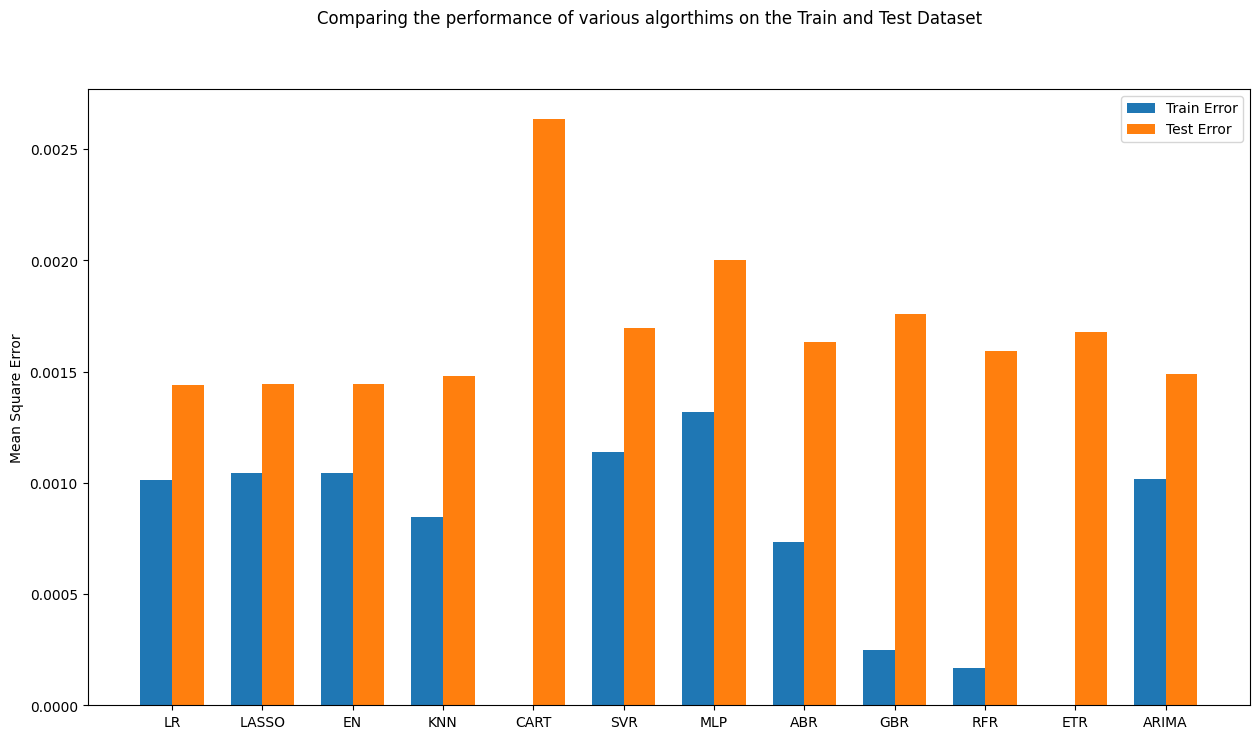

In [18]:
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('Mean Square Error')
plt.show()

Analisando o gráfico acima, ainda temos que os algoritmos lineares (LASSO e EN) estão melhor performando, isso pode ser principalmente devido uma forte relação linear entre as variáveis.

In [19]:
min_test_error_index = np.argmin(test_results)
min_test_error = test_results[min_test_error_index]

In [20]:
min_test_error_index = np.argmin(test_results)
min_test_error = test_results[min_test_error_index]
algorithm_with_min_error = names[min_test_error_index]
print(f"O algoritmo com a menor taxa de erro nos dados de teste e: {algorithm_with_min_error}, com o valor: {min_test_error:.9f}")


O algoritmo com a menor taxa de erro nos dados de teste e: LR, com o valor: 0.001438386


# 4.0. Hyperparameter tunning

In [21]:
from hyperopt import hp, fmin, tpe, Trials

In [22]:
space = {
    'alpha': hp.loguniform('alpha', -6, 2),  # Intervalo loguniform para 'alpha'
    'max_iter': hp.choice('max_iter', [100, 500, 1000, 3000, 4000])  # Valores discretos para 'max_iter'
}

# Função objetivo para otimização (usando erro médio quadrado negativo)
def objective(params):
    lasso = Lasso(alpha=params['alpha'], max_iter=params['max_iter'])
    lasso.fit(X_train, Y_train)
    y_pred = lasso.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred)
    return -mse  # Negativo, pois o hyperopt minimiza

# Inicializar o objeto Trials para registrar os resultados
trials = Trials()

# Executar a otimização com o algoritmo TPE (Tree-structured Parzen Estimator)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5000, trials=trials)

# Obter os melhores parâmetros encontrados
best_params = {
    'alpha': best['alpha'],
    'max_iter': [100, 500, 1000, 3000, 4000][best['max_iter']]
}

print("Melhores parâmetros encontrados:")
print(best_params)


100%|██████████| 5000/5000 [02:05<00:00, 39.97trial/s, best loss: -0.001442578976764135]
Melhores parâmetros encontrados:
{'alpha': 0.003109818155626185, 'max_iter': 100}


In [25]:
model_tuned = Lasso(alpha=best_params['alpha'],
                    max_iter=best_params['max_iter'])
model_tuned.fit(X_train, Y_train)


Lasso(alpha=0.003109818155626185, max_iter=100)

In [26]:
predicted_tuned = model_tuned.predict(X_test)
print(mean_squared_error(Y_test,predicted_tuned))

0.001442578976764135


In [27]:
min_test_error==mean_squared_error(Y_test,predicted_tuned)

False

Os esforços em otimizar o desempenho do modelo por meio do ajuste de hiperparâmetros deu resultando, sendo assim os melhores parâmetros foram encontrado pois houve uma melhora na métrica de avaliação da performance do modelo.

# 5.0. Comparision between predicted and real values

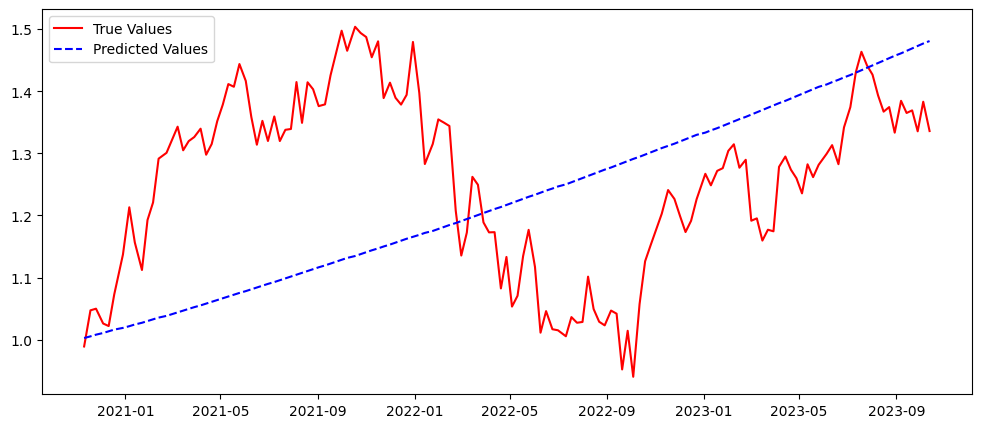

In [30]:
predicted_df = pd.DataFrame(predicted_tuned, columns=['Predicted'])

# Definir o índice do DataFrame predicted_df conforme o índice do Y_test
predicted_df.index = Y_test.index

# Plotar os resultados
plt.plot(np.exp(Y_test).cumprod(), 'r', label='True Values')
plt.plot(np.exp(predicted_df['Predicted']).cumprod(), 'b--', label='Predicted Values')
plt.rcParams["figure.figsize"] = (12, 3)
plt.legend()
plt.show()

Ao observar o gráfico, fica claro que a tendência está sendo capturada pelo modelo, dado que o modelo é uma linha de regressão. A série prevista é menos volátil em comparação com a série temporal real e se alinha aos dados reais nos primeiros meses do conjunto de testes e no final do ano de 2022. Vale destacar que o objetivo do modelo é calcular o retorno do próximo dia com base nos dados observados até o dia presente, e não prever o preço das ações vários dias no futuro com base nos dados atuais. Portanto, é esperado um desvio em relação aos dados reais à medida que nos afastamos do início do conjunto de testes. O modelo parece ter um bom desempenho nos primeiros meses, mas o desvio em relação aos dados reais aumenta nos anos posteriores.

# 6.0. Sugestão de utilização do resultado

Como analista de investimento, vou analisar os dados reais e previstos para as ações da JPM (JPMorgan Chase & Co.) nos últimos dez dias e fornecer uma avaliação de risco e lucratividade, bem como uma recomendação de compra para o próximo dia.

**Análise de Risco e Lucratividade:**

- Tendência de Alta: Nos últimos dez dias, observamos uma tendência de queda nos preços reais das ações da JPM, que cairam de 1.393386 para 1.336003, o que é um sinal negativo.

- Previsões do Modelo: As previsões do modelo indicam uma tendência de alta consistente e estão em linha com a tendência dos preços reais. Isso é um ponto positivo, pois o modelo parece estar capturando a tendência atual do mercado.

- Confiabilidade do Modelo: A consistência entre as previsões do modelo e os preços reais é um sinal de que o modelo está funcionando bem no momento. No entanto, é importante lembrar que previsões passadas não garantem o desempenho futuro.

- Horizonte de Previsão: As previsões do modelo se estendem por um período de dez dias. É importante observar que a precisão de previsões de longo prazo pode ser mais desafiadora, e a volatilidade do mercado pode influenciar o desempenho das ações da JPM.

**Recomendação de Compra:**

Com base na análise dos dados e do modelo, a recomendação para a compra da ação da JPM para o próximo dia depende de sua estratégia e apetite ao risco. Aqui estão algumas considerações:

1. Tendência de Alta Real: A tendência real dos preços das ações da JPM nos últimos dez dias tem sido de queda, o que poderia levantar preocupações sobre a continuação dessa tendência.

2. Previsões do Modelo: As previsões do modelo indicam uma tendência de alta, o que é um sinal positivo. No entanto, é importante lembrar que previsões de curto prazo podem variar e não garantem resultados futuros.

3. Risco e Volatilidade: A volatilidade do mercado pode afetar o desempenho das ações. Como analista, é importante considerar seu nível de tolerância ao risco ao tomar decisões de investimento.

4. Diversificação: Além de considerar a compra de ações da JPM, é importante avaliar sua carteira de investimentos como um todo e garantir uma diversificação adequada.

Em resumo, a recomendação de compra da ação da JPM para o próximo dia dependerá de sua análise pessoal e estratégia de investimento. A tendência de alta nas previsões do modelo é um ponto positivo, mas a tendência de queda real dos preços nos últimos dias pode aumentar o risco. Certifique-se de realizar uma análise completa, considerar sua tolerância ao risco e manter uma estratégia de gestão de riscos adequada ao tomar decisões de investimento.